In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# %pip install lightgbm
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler

/var/folders/jh/zgqt24qj3_n6m12h05s8spkr0000gn/T/ipykernel_9997/3128864870.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
random_state=123
best_models = {}

In [3]:
# Read in the data
df = pd.read_csv(r'../Data/Final_skin_cancer.csv')

df.drop('drink', axis=1, inplace=True)

df.drop_duplicates(inplace=True)

df



,smoke,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,diagnostic
0,False,55,False,0,True,True,True,True,1
1,False,79,False,1,True,False,False,False,1
2,False,52,False,0,False,True,True,True,1
3,False,74,True,0,False,False,False,False,1
4,False,58,True,0,True,True,True,True,1
...,...,...,...,...,...,...,...,...,...
1692,False,33,False,0,False,True,True,True,0
1696,False,55,True,0,True,True,True,True,0
1698,False,55,True,0,False,True,False,True,0
1702,True,23,False,1,False,False,True,True,0


In [4]:
df.duplicated().sum()

0

# New Section

In [5]:
from sklearn.model_selection import train_test_split

def splitting_data(df, sampling, test_size=0.2, random_state=123):
    # First, split the data into features and target variable
    X = df.drop(['diagnostic'], axis=1)
    y = df['diagnostic']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply sampling methods to the training data based on the specified method
    if sampling == 'none':
        return X_train, X_test, y_train, y_test
    elif sampling == 'SMOTEENN':
        from imblearn.combine import SMOTEENN
        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'SMOTE':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'under':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'over':
        from imblearn.over_sampling import RandomOverSampler
        rus = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test

In [6]:

def training(X_train, y_train):
    # Create a ET classifier with 5 neighbors
    ET = ExtraTreesClassifier()
    # Fit the classifier to the data
    ET.fit(X_train, y_train)
    return ET

In [7]:
def best_model(modelName, accuracy, precision, recall, f1):
    best_models[modelName] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [8]:
def predict(modleName,ET, X_test ,y_test):
    # Predict the labels for the training data X
    y_pred = ET.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr=classification_report(y_test, y_pred, output_dict=True)
    precision = cr['weighted avg']['precision']
    recall = cr['weighted avg']['recall']
    f1 = cr['weighted avg']['f1-score']
    best_model(modleName,accuracy,precision,recall,f1)
    cr=classification_report(y_test, y_pred)
    print(cr)

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def optimize_with_grid(X_train, y_train):
    # Define a pipeline
    # Note: Scaling might not be necessary for tree-based models, but included for consistency
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Optional for ExtraTrees
        ('extra_trees', ExtraTreesClassifier(random_state=random_state))
    ])

    # Define the parameter grid to search
    param_grid = {
        'extra_trees__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'extra_trees__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'extra_trees__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'extra_trees__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'extra_trees__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
    }

    # Create the GridSearchCV object
    extra_trees_cv = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

    # Perform the grid search on the provided data
    extra_trees_cv.fit(X_train, y_train)

    # Best parameters and best score
    best_params = extra_trees_cv.best_params_
    best_score = extra_trees_cv.best_score_
    best_estimator = extra_trees_cv.best_estimator_
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_estimator

# Example usage
# Ensure you have defined X_train, y_train, and optionally random_state before calling this function
# best_extra_trees_model = optimize_with_grid_extra_trees(X_train, y_train, random_state=42)


<h1> ET on original data with optimization </h1>

In [10]:
# using function with no sampling
X_train, X_test, y_train, y_test = splitting_data(df, 'none')
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#check number of observations in each class in the set
print("Number of observations in each class in the training set:")
print(y_train.value_counts())

Number of observations in each class in the training set:
diagnostic
1    565
0    114
Name: count, dtype: int64


In [12]:
ET1 = training(X_train, y_train)
y_pred = predict('original',ET1, X_test, y_test)


              precision    recall  f1-score   support

           0       0.52      0.64      0.57        25
           1       0.94      0.90      0.92       145

    accuracy                           0.86       170
   macro avg       0.73      0.77      0.74       170
weighted avg       0.87      0.86      0.86       170



In [13]:
best_ET = optimize_with_grid(X_train, y_train)
prediction = predict('original_grid',best_ET, X_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Best Parameters: {'extra_trees__max_depth': 10, 'extra_trees__max_features': 'log2', 'extra_trees__min_samples_leaf': 4, 'extra_trees__min_samples_split': 10, 'extra_trees__n_estimators': 100}
Best Score: 0.8909803921568628
              precision    recall  f1-score   support

           0       0.74      0.68      0.71        25
           1       0.95      0.96      0.95       145

    accuracy                           0.92       170
   macro avg       0.84      0.82      0.83       170
weighted avg       0.92      0.92      0.92       170



/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hneen/miniconda3/lib/python3.11/site-packages/sklearn/pipeline.py", li

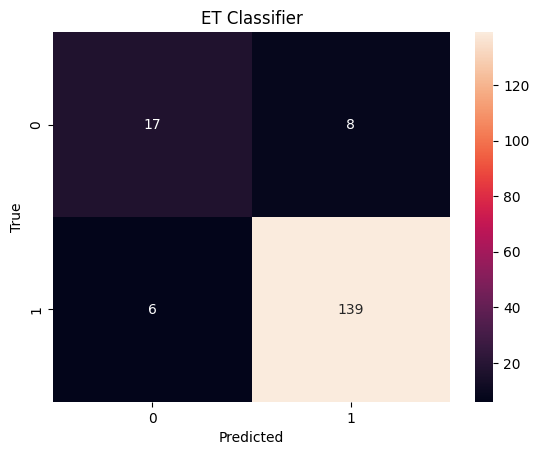

In [14]:
# plot the confusion matrix for the model
y_pred = best_ET.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ET Classifier')
plt.show()